In [256]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [257]:
from swdb_2018_neuropixels.ephys_nwb_adapter import NWB_adapter    

In [258]:
drive_path = '/data/dynamic-brain-workshop/visual_coding_neuropixels'

In [259]:
manifest_file = os.path.join(drive_path,'ephys_manifest.csv')
expt_info_df = pd.read_csv(manifest_file)
multi_probe_expt_info = expt_info_df[expt_info_df.experiment_type == 'multi_probe']
multi_probe_example = 1 # index to row in multi_probe_expt_info
multi_probe_filename  = multi_probe_expt_info.iloc[multi_probe_example]['nwb_filename']
nwb_file = os.path.join(drive_path,multi_probe_filename)
data_set = NWB_adapter(nwb_file)

In [260]:
from downsampling_module import downsample_images

In [261]:
nat_scenes = np.load('natural_scenes.npy')

In [262]:
ds_nat_scenes = np.array(downsample_images(nat_scenes, 25, 25))
ds_nat_scenes = ds_nat_scenes*(1.0/255.0)

(36, 46)


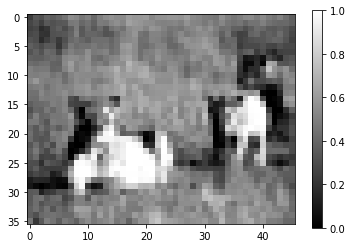

In [263]:
print(ds_nat_scenes[1].shape)
plt.imshow(ds_nat_scenes[7], cmap='gray')
plt.colorbar()

In [264]:
from downsampling_module import flatten_images

In [265]:
flattened_image_list = flatten_images(np.array(ds_nat_scenes))

In [266]:
stim_table = data_set.get_stimulus_table('natural_scenes')

In [267]:
def get_frame_at_time(time, stim_table):
    starts = stim_table.start.values
    idx = np.searchsorted(starts, time)-1
    return(stim_table.iloc[idx].values[2])

In [268]:
def get_stim_time_array(stim_table, tns_start, tns_end, bin_len, flattened_image_list):
    T = int(np.floor((tns_end - tns_start)/bin_len))
    time_array = np.linspace(tns_start,tns_end,T)
    stim_array = []
    for idx, time_point in enumerate(time_array):
        stim_index = get_frame_at_time(time_point, stim_table)
        stim_array.append(flattened_image_list[int(stim_index)])
    return(stim_array, time_array)

In [269]:
bin_len = 0.001
num_stim_rows = 100
tns_start = stim_table.iloc[0].values[0]
tns_end = stim_table.iloc[num_stim_rows].values[1]
print(tns_start)
print(tns_end)

5908.725920000001
5933.995830000002


In [270]:
[stim_array, time_array] = get_stim_time_array(stim_table,tns_start,tns_end,bin_len,flattened_image_list)
print(tns_start)
print(tns_end)

5908.725920000001
5933.995830000002


In [271]:
print(np.shape(stim_array))

(25269, 1656)


In [272]:
# print(time_array.shape)
# print(np.array(stim_array).shape)

# time_array_short = time_array[0:len(time_array)/4]
# stim_array_short = stim_array[:,:len(time_array)/4]
# print(time_array_short.shape)
# print(np.array(stim_array_short).shape)

tns_start = time_array[0]
tns_end = time_array[-1]
print(tns_start)
print(tns_end)

print(time_array.shape)


5908.725920000001
5933.995830000002
(25269,)


In [273]:
from GLM_helpers import bin_spikes
(binned_spikes, cell_table) = bin_spikes(data_set,bin_len,tns_start,tns_end,regions=['VISp'])

In [274]:
reduced_spikes = binned_spikes[0:5,:]

In [275]:
reduced_spikes.shape

(5, 25269)

In [276]:
def construct_GLM_mat(flat_stimulus, binned_spikes, i, d_stim, d_spk):
    (N,T) = binned_spikes.shape # N is number of neurons, T is number of time bins
    (M,T) = flat_stimulus.shape # M is the size of a stimulus
    X_dsn = np.empty((T-d_stim+1,M*d_stim+N*d_spk))
    d_max = max(d_stim,d_spk)
    y = np.empty((T-d_max+1,))
    for t in range(T-d_max+1):
        y[t] = binned_spikes[i,t+d_max-1]
        X_dsn[t,:M*d_stim] = flat_stimulus[:,t+d_max-d_stim:t+d_max].reshape((1,-1))
        X_dsn[t,M*d_stim:] = binned_spikes[:,t+d_max-d_spk:t+d_max].reshape((1,-1))
    return (y, X_dsn)   

In [319]:
import keras
from keras import backend as K
from keras.models import Model
from keras.layers import Input
from keras import Sequential
from keras.layers import Dense, Lambda
from keras.regularizers import Regularizer
def GLM_network_fit(stimulus,spikes,d_stim, d_spk,bin_len,f='exp',priors=None,L1=None):
    N = spikes.shape[0]
    print("N", N)
    M = stimulus.shape[0]
    print("M", M)
    F = np.empty((N,M,d_stim)) # stimulus filters
    W = np.empty((N,N,d_spk))  # spike train filters
    b = np.empty((N,)) # biases
    fs = {'exp':K.exp}
    for i in range(1):
        [y, Xdsn] = construct_GLM_mat(np.array(stim_array), binned_spikes, i, d_stim, d_spk)
        print(y.shape)
        model = Sequential()
        model.add(Dense(1,input_dim = Xdsn.shape[1],use_bias=True, kernel_regularizer=SparseGroupLasso(M*d_stim,d_spk,lgroup=0.00001)))
        model.add(Lambda(lambda x: fs[f](x)*bin_len))
        model.compile(loss = 'poisson',optimizer = keras.optimizers.adam(lr=1e-1))
        model.fit(x=Xdsn,y=y,epochs=20, verbose=1)
        p = model.get_weights()[0]
        print("pshape", p.shape)
        print("Mdstim", M*d_stim)
        F[i,:,:] = p[:M*d_stim].reshape((M,d_stim))
        W[i,:,:] = p[M*d_stim:].reshape((N,d_spk))
        b[i] = model.get_weights()[1]
    return (F,W,b)


In [320]:
#kernel_regularizer=SparseGroupLasso(M*d_stim,d_spk,lgroup=0))

In [321]:
from keras.regularizers import Regularizer
from keras import backend as K

class SparseGroupLasso(Regularizer):
    """Regularizer for group lasso regularization.
    # Arguments
       l1: Float; L1 regularization factor.
       l2: Float; L2 group regularization factor.
   """

    def __init__(self, size_stim, d_spike, lgroup = 1.):
        self.lgroup = K.cast_to_floatx(lgroup)
        self.d_spike = d_spike
        self.size_stim = size_stim

    def __call__(self, x): 
        xr = K.reshape(x[self.size_stim:], (-1, self.d_spike))
        return(self.lgroup * np.sqrt(K.int_shape(xr)[1])*K.sum(K.sqrt(K.sum(K.square(xr),axis=1))))


In [ ]:
[F, W, b] = GLM_network_fit(np.array(stim_array),binned_spikes,15,15, bin_len)

('N', 71)
('M', 25269)
(1642,)
Epoch 1/20
1642/1642 [==============================] - 7s 4ms/step - loss: 2.2883e-04
Epoch 2/20
1642/1642 [==============================] - 5s 3ms/step - loss: 5.1163e-05
Epoch 3/20
1642/1642 [==============================] - 5s 3ms/step - loss: 5.2387e-05
Epoch 4/20
1642/1642 [==============================] - 5s 3ms/step - loss: 5.3987e-05
Epoch 5/20
1642/1642 [==============================] - 5s 3ms/step - loss: 5.4419e-05
Epoch 6/20
1642/1642 [==============================] - 5s 3ms/step - loss: 5.6330e-05
Epoch 7/20
1642/1642 [==============================] - 5s 3ms/step - loss: 5.7039e-05
Epoch 8/20
1642/1642 [==============================] - 5s 3ms/step - loss: 5.5068e-05
Epoch 9/20
1642/1642 [==============================] - 5s 3ms/step - loss: 5.4699e-05
Epoch 10/20
1642/1642 [==============================] - 5s 3ms/step - loss: 5.5959e-05
Epoch 11/20
1642/1642 [==============================] - 5s 3ms/step - loss: 5.7212e-05
Epoch 12/2

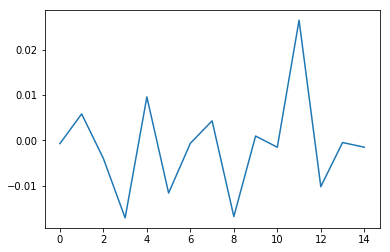

In [318]:
plt.plot(W[5][6]) 